<a href="https://colab.research.google.com/github/AkihitoSawai/colaboratory/blob/master/MLModel_Analysis2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Driveとの連携

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# 各種import

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from random import shuffle
from scipy import misc
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.xception import Xception
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from keras.utils.np_utils import to_categorical
from keras.callbacks import Callback
from keras.initializers import TruncatedNormal
from PIL import Image
from statistics import mean

Using TensorFlow backend.


# 補助関数

In [0]:
#損失関数のhistory(y軸：mae)
def plot_history_mae(history, title):
  plt.figure()
  plt.title(title)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error ')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0,12])


#損失関数のhistory(y軸：mse)
def plot_history_mse(history, title):
  plt.figure()
  plt.title(title)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error ')
  plt.plot(history.epoch, np.array(history.history['mean_squared_error']),
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_squared_error']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0,12])

#epoch完了ごとに#を出力(progress)
class PrintSharp(Callback):
  def on_epoch_end(self,epoch,logs):
    if epoch % 100 == 0: print('')
    print('#', end='')

#データロード関数。
def Data_load(UTKFacePass:str):
    os.chdir(UTKFacePass)
    X_train  = np.load("X_5000_noAsian.npy", allow_pickle = True)
    Y_train  = np.load("Y_5000_noAsian.npy", allow_pickle = True)
    X_test  = np.load("X_1000_Asian.npy", allow_pickle = True)
    Y_test  = np.load("Y_1000_Asian.npy", allow_pickle = True)
    
    return X_train, Y_train, X_test, Y_test

# 学習実行関数

In [0]:
#モデル学習の実行関数。
def model_fit(model,          #学習モデル
              model_name:str, #学習モデルの名前(学習曲線図の題名で使う。)
              epochs:int,     #エポック数
              batch_size:int, #バッチサイズ
              X_train,        #Trainning Feature(学習用の画像)
              Y_train,        #Trainning Target(学習用の年齢ラベル)
              X_test,         #Test Feature(評価用の画像)
              Y_test,         #Test Target(評価用の年齢)
              Loss:str,       #学習に用いる損失関数
              optimizer:str   #最適化関数
             ):
  
    #コンパイル
    model.compile(loss=Loss,
                 optimizer=optimizer,     
                 metrics=['mae','mse']
                 )
    
    #モデル学習実行
    hist = model.fit(X_train,
                        Y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data = (X_test, Y_test),      #検証に使われるdata
                        verbose=0,                               #ログ出力しない
                        callbacks=[PrintSharp()]
                       )
    
    #学習曲線(y軸はmae)
    plot_history_mae(hist, model_name)
    #TestDataの評価
    [Test_loss, Test_mae, Test_mse] = model.evaluate(X_test, Y_test, verbose=0)
    #TrainDataの平均mae(40~100epoch)
    Train_mae_mean = mean(hist.history["mean_absolute_error"][40:100])
    #TestDataの平均mae(40~100epoch)
    Test_mae_mean = mean(hist.history['val_mean_absolute_error'][40:100])
    
    
    #train,test dataのmae, mseを返す。
    return Test_mae, Test_mse, Train_mae_mean, Test_mae_mean

# 学習モデル

In [0]:
#学習モデル(転移学習モデルと結合層を固めたもの。)
def ML_model(Transfer_model):     

    #結合層
    flatten_model = Sequential()
    flatten_model.add(
        Flatten(
            input_shape = Transfer_model.output_shape[1:]
        ))
    flatten_model.add(
        Dense(256,
              activation = "relu"
             ))
    flatten_model.add(Dropout(0.25))
    flatten_model.add(
        Dense(1,
              activation = 'linear',
             ))
    
    # ResNet50と結合層を結合してモデルを作成
    model = Model(
        input = Transfer_model.input,           #転移学習モデル
        output = flatten_model(Transfer_model.output) #結合層
    )
    
    model.summary()
    
    return model

# 学習実行













83689472/83683744 [==============================] - 4s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 99, 99, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`





####################################################################################################

Test_mae:6.467417198181153
Test_mse:68.4958256225586
Test_mae_mean - Train_mae_mean:3.9072733978033063
CPU times: user 2h 43min, sys: 1h 23min 46s, total: 4h 6min 47s
Wall time: 5h 27min 19s


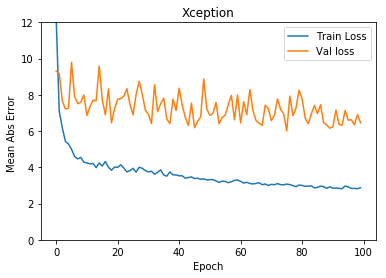

In [0]:
%%time

#Trainデータ、Testデータのローディング。
UTKFacePass = '/content/drive/My Drive/UTKface_AgePrediction'
X_train, Y_train, X_test, Y_test = Data_load(UTKFacePass)

#画像のサイズ
input_size = (200, 200, 3)
#転移学習モデ(※注意　変更ポイント)
Transfer_model = Xception(include_top=False,                         #結合層はつけない。(自前(Flatten)で用意する。)
                          weights='imagenet',                     #imagenetの学習済みパラメータ
                          input_tensor=Input(shape = input_size)  #input(画像)のサイズ
                         )
#model構築
model = ML_model(Transfer_model)

#学習実行。
Train_mae=0
Train_mse=0
Test_mae=0
Test_mse=0

#(※注意　変更ポイント)
Test_mae, Test_mse, Train_mae_mean, Test_mae_mean = model_fit(
                     model,          #学習モデル
                     "Xception",     #学習モデルの名前(学習曲線図の題名で使う。)
                     100,            #エポック数
                     50,             #バッチサイズ
                     X_train,        #Trainning Feature(学習用の画像)
                     Y_train,        #Trainning Target(学習用の年齢ラベル)
                     X_test,         #Test Feature(評価用の画像)
                     Y_test,         #Test Target(評価用の年齢ラベル)
                     "mae",          #学習に用いる損失関数
                     "Adamax"        #最適化関数(※注意　変更ポイント)
                    )  
print("\n")
#mae: 年齢予測の誤差
#mse: 年齢予測の散らばり具合を表す。maeに近いほど安定した予測を出す。
print("Test_mae:{0}".format(Test_mae))
print("Test_mse:{0}".format(Test_mse))


#TrainDataとTestDataのmae(年齢予測の誤差)の差。
#大きすぎると過学習の疑いが強くなる。(40~100epoch)
print("Test_mae_mean - Train_mae_mean:{0}".format(Test_mae_mean - Train_mae_mean))